<a href="https://colab.research.google.com/github/shuodeng521-sys/ST-554-Project1-Shuo-Anna-Jillian/blob/main/Task2/Greene_Project1_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Monitoring carcinogenic atmospheric pollutants is imperative for mitigating negative public health crises, though current sensing technologies are expensive and labor-intensive. [De Vito et al. (2008)](https://doi.org/10.1016/j.snb.2007.09.060) suggest a low-cost gas multi-sensor device capable or providing high resolution data for CO, NMHCs, NOx, NO2, and O3 with a machine learning approach for calibration. If successful, this type of set up could provide city, state, and federal planners and managers with critical information on how to protect human health. In this project, our team will be exploring the data to find the optimal way to set up a model and analyze covariates for the sensor. Data can be downloaded from the [UCI ML Repository](https://archive.ics.uci.edu/dataset/360/air+quality) or read in following to code below.

In [7]:
# Install UCI package - only needs to be done 1st time
# !pip install ucimlrepo

# Import the package
from ucimlrepo import fetch_ucirepo

# Fetch the Air Quality Multisensor dataset
air_quality = fetch_ucirepo(id=360)

# Print var info
air_quality.variables

,name,role,type,demographic,description,units,missing_values
0,Date,Feature,Date,None,None,None,no
1,Time,Feature,Categorical,None,None,None,no
2,CO(GT),Feature,Integer,None,True hourly averaged concentration CO in mg/m^...,mg/m^3,no
3,PT08.S1(CO),Feature,Categorical,None,hourly averaged sensor response (nominally CO...,None,no
4,NMHC(GT),Feature,Integer,None,True hourly averaged overall Non Metanic Hydro...,microg/m^3,no
5,C6H6(GT),Feature,Continuous,None,True hourly averaged Benzene concentration in...,microg/m^3,no
6,PT08.S2(NMHC),Feature,Categorical,None,hourly averaged sensor response (nominally NMH...,None,no
7,NOx(GT),Feature,Integer,None,True hourly averaged NOx concentration in ppb...,ppb,no
8,PT08.S3(NOx),Feature,Categorical,None,hourly averaged sensor response (nominally NOx...,None,no
9,NO2(GT),Feature,Integer,None,True hourly averaged NO2 concentration in micr...,microg/m^3,no


In [8]:
# Import auxillary packages for Task 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import math

In [9]:
# Convert to pandas df
air_quality = pd.DataFrame(air_quality.data.features)

# Rename columns
air_quality.rename(columns = {'CO(GT)' : "True_CO", "PT08.S1(CO)" : "PT_CO", "NMHC(GT)" : "True_NMHC",
                              "C6H6(GT)" : "True_C6H6", "PT08.S2(NMHC)" : "PT_NMHC", "NOx(GT)" : "True_NOx",
                              "PT08.S3(NOx)" : "PT_NOx", "NO2(GT)" : "True_NO2", "PT08.S4(NO2)" : "PT_NO2",
                              "PT08.S5(O3)" : "PT_NO3"}, inplace = True)

air_quality.head()

,Date,Time,True_CO,PT_CO,True_NMHC,True_C6H6,PT_NMHC,True_NOx,PT_NOx,True_NO2,PT_NO2,PT_NO3,T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [10]:
# Check for NAs
# In the metadata, -200s are NA, so set accordingly
air_quality.replace(-200, np.nan, inplace = True)

air_quality.isna().sum()

,0
Date,0
Time,0
True_CO,1683
PT_CO,366
True_NMHC,8443
True_C6H6,366
PT_NMHC,366
True_NOx,1639
PT_NOx,366
True_NO2,1642


There are many rows with NAs, particularly in the 'True' columns which is consistent with ML datasets, i.e. this is why we need a model! For this exploratory analysis, it would be overzealous to remove all NAs. I will remove NAs in the sensor columns which seem consistent throughout all variables.

In [11]:
# Remove NAs in 1 sensor column (PT_CO) and check for NAs to see if that addresses all
air_quality.dropna(subset = ["PT_CO"], inplace = True)
air_quality.isna().sum()

,0
Date,0
Time,0
True_CO,1647
PT_CO,0
True_NMHC,8104
True_C6H6,0
PT_NMHC,0
True_NOx,1595
PT_NOx,0
True_NO2,1598


All NAs were removed in the sensor and climate columns by removing NAs just in the sensor CO column as predicted. This has addressed the issue and I can move on to the Task 2 analysis.

## Preliminary data exploration

To begin, I'd like to make a correlation matrix colored respecitvely with the `seaborn` package for easy identification of which variables are related. For this, I will drop the `Date`, `Time`, and `True_` columns

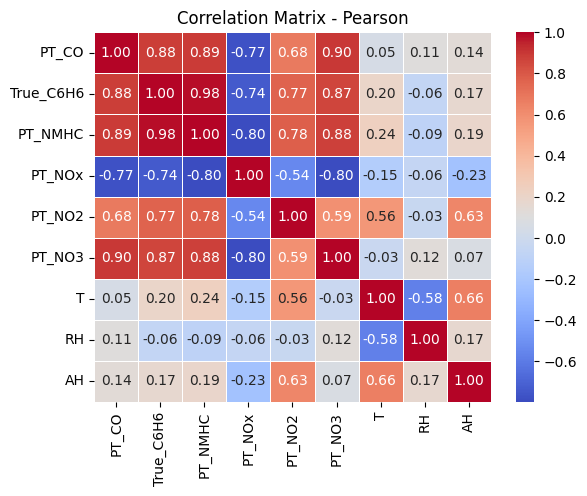

In [12]:
# Create new df for matrix
# Create drop clause with wildcard
drop_trues = [col for col in air_quality.columns if col.startswith("True_") and col != "True_C6H6"]

matrix_df = air_quality.drop(columns=drop_trues + ["Date", "Time"])

# Create correlation matrix - Pearson correlation
corr_matrix = matrix_df.corr()

# Plot using seaborn
sns.heatmap(corr_matrix,
            annot=True, # Add correlation number
            cmap='coolwarm', # Color map
            fmt='.2f', # 2 decimal place
            linewidths=0.5)
# Add title
plt.title('Correlation Matrix - Pearson')
plt.show()



This very clearly shows us that all of the sensor readings are strongly correlated with one another, though not always positively. The climate variables (temperature (`T`) and absolute (`AH`) or relative humidity (`RH`)) have weak linear relationships with the sensor gas concentrations.

The strongest relationship between climate and gas is `T` and `AH` with nitrogen dioxide (`PT_NO2`), 0.56 and 0.63, respectively. There is an interestingly weak relationship between `RH` and `PT_NO2` as generally, relative humidity takes in the amount of water in the air relative to its temperature while absolute humidity is just water content. Though, through my personal experience with gas and temperature/humidity sensors, I know it's common to calculate `AH` from `T`, though it is not explained in the literature from where `AH` is derived. This could be the case here in explaining why `T` and `AH` have strong relationships with `PT_NO2` but not `RH`. This can also be seen by their stronger, positive relationship with each other (0.66).

In the case of non-linear relationships, I am going to run this test again but specifying a Spearman correlation as opposed to Pearson to see if I can tease out any stronger climate-to-gas relationships.

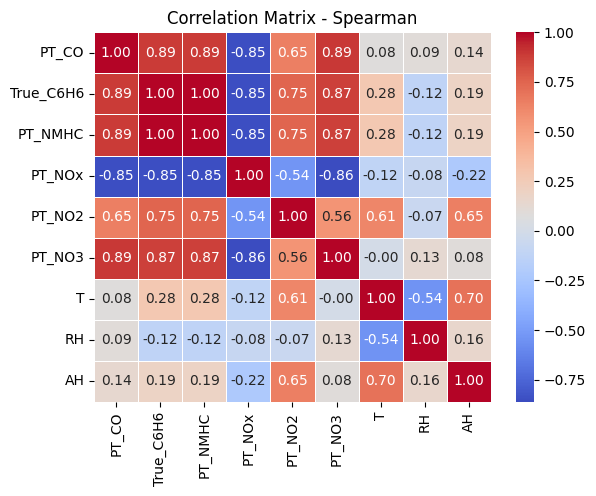

In [13]:
# Rerun correlation matrix but with Spearman corr.
sp_corr_matrix = matrix_df.corr(method="spearman")

# Plot using seaborn
sns.heatmap(sp_corr_matrix,
            annot=True, # Add correlation number
            cmap='coolwarm', # Color map
            fmt='.2f', # 2 decimal place
            linewidths=0.5)
# Add title
plt.title('Correlation Matrix - Spearman')
plt.show()

No large changes, but slightly stronger correlations between the `T` and sensor gases. This is likely a result of better handling of outliers, but I'll plot these relationships next to see what's going on.

## Scatterplots

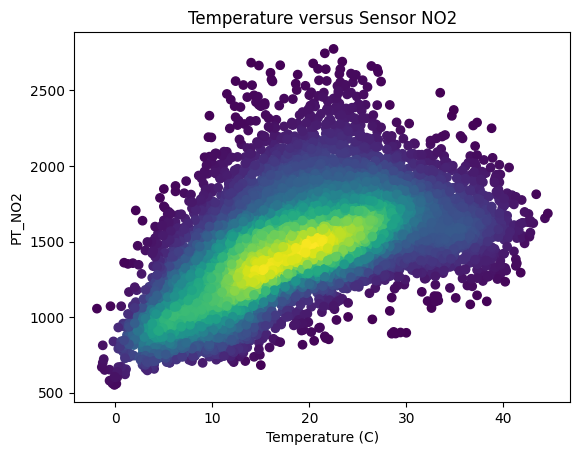

In [14]:
# Plot PT_NO2 vs T (spearman corr = 0.61)

# Set up color density gradient
values = np.vstack((matrix_df["T"], matrix_df["PT_NO2"]))
kernel = gaussian_kde(values)
kde = kernel.evaluate(values)

# Create plot
plt.scatter(matrix_df["T"], matrix_df["PT_NO2"], c=kde, cmap='viridis')
plt.xlabel("Temperature (C)")
plt.ylabel("PT_NO2")
plt.title("Temperature versus Sensor NO2")
plt.show()

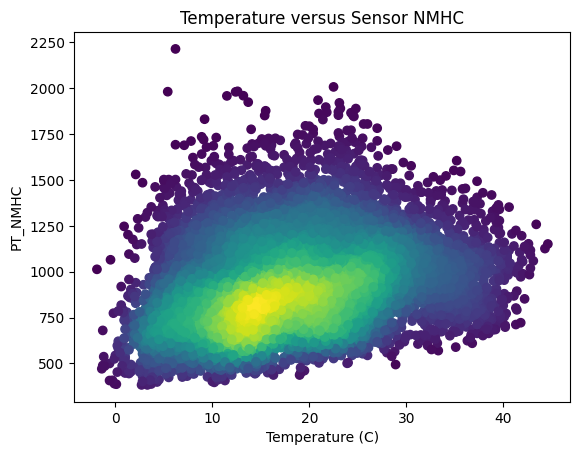

In [15]:
# Plot NMHC vs T (spearman corr = 0.28)
# Set up color density gradient
values = np.vstack((matrix_df["T"], matrix_df["PT_NMHC"]))
kernel = gaussian_kde(values)
kde = kernel.evaluate(values)

# Create plot
plt.scatter(matrix_df["T"], matrix_df["PT_NMHC"], c=kde, cmap='viridis')
plt.xlabel("Temperature (C)")
plt.ylabel("PT_NMHC")
plt.title("Temperature versus Sensor NMHC")
plt.show()

As expected, there are a lot of outliers in both plots of `T` against `PT_NO2` and `PT_NMHC`, but the relationship is visibily weaker between `T` and `PT_NMHC`, which is now corroborated quantitatively and qualitatively.

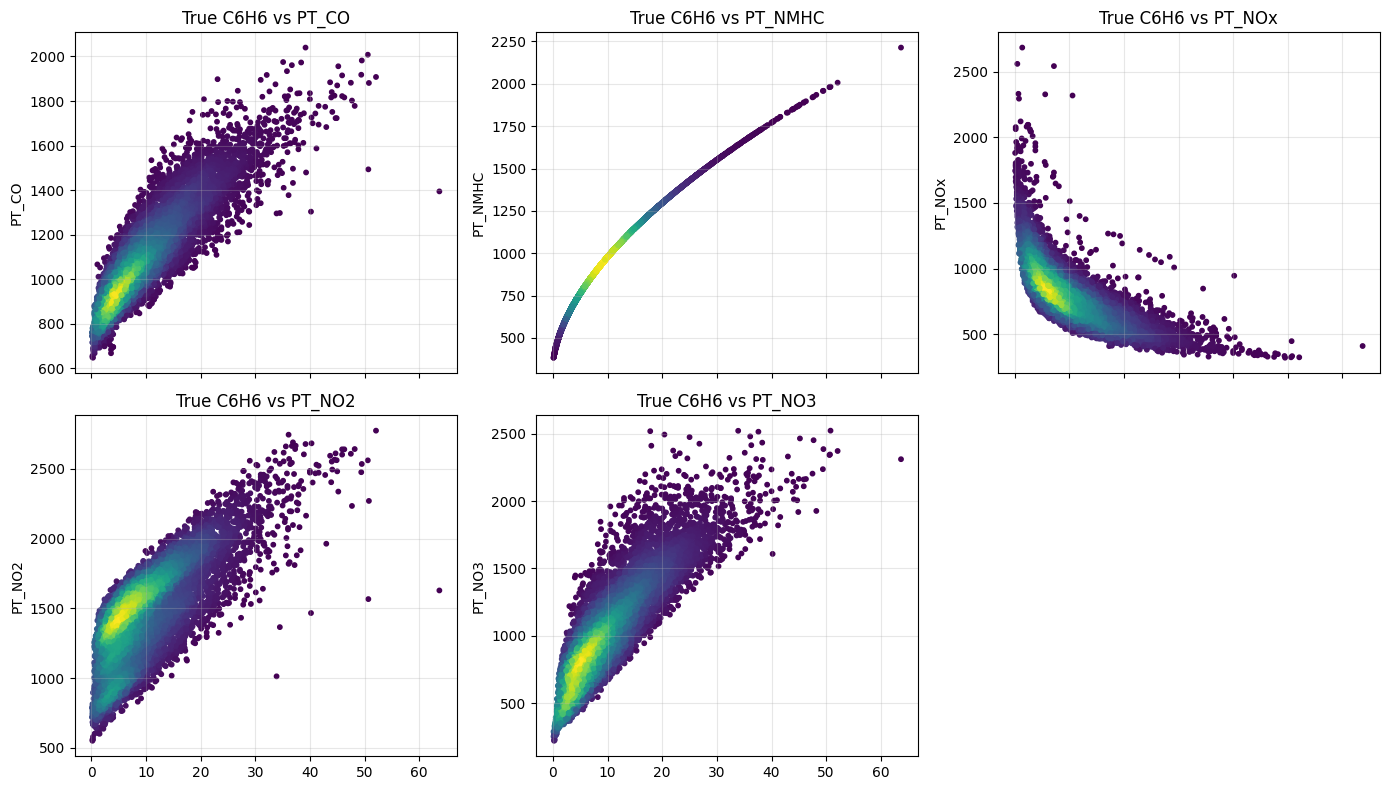

In [16]:
# Create 5-panel scatterplot of C6H6 against other sensor gases
x = air_quality["True_C6H6"]

y_cols = ["PT_CO", "PT_NMHC", "PT_NOx", "PT_NO2", "PT_NO3"]
# 2 x 3 plots
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)
axes = axes.flatten()

for ax, y_col in zip(axes, y_cols):
    y = air_quality[y_col]

    # KDE density coloring
    values = np.vstack((x, y))
    kernel = gaussian_kde(values)
    kde = kernel(values)

    sc = ax.scatter(x, y, c=kde, cmap="viridis", s=10)

    ax.set_title(f"True C6H6 vs {y_col}", fontsize=12)
    ax.set_ylabel(y_col)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("True C6H6")
axes[-1].axis("off")


plt.tight_layout()
plt.show()


All of the gases have strong relationships with `C6H6` with more noise in the higher ranges. It is clear that the `PT_NMHC` has a perfect relationship for modeling true C6H6. Lastly, I'll create the same type of plots with the climate variables, which from the correlation matrices, I expect to have significantly worse relationships.

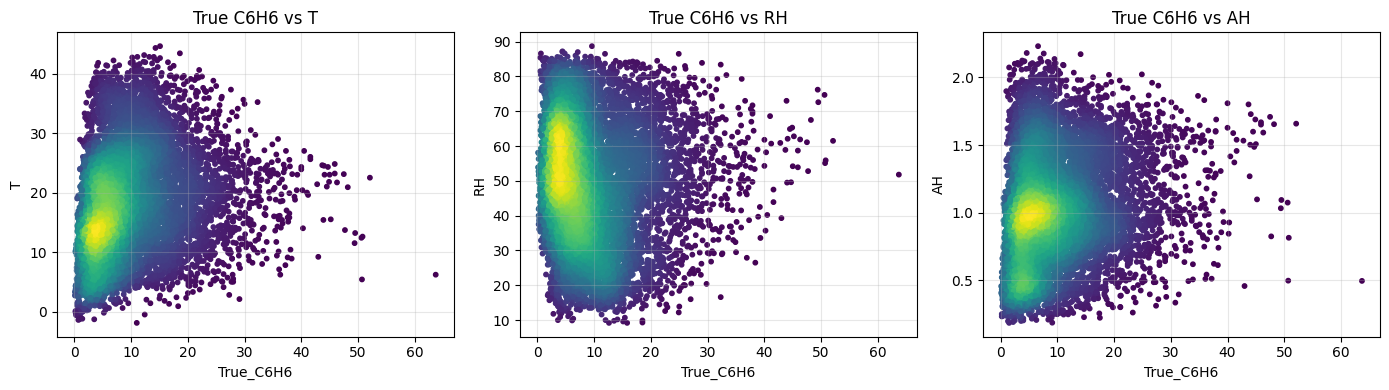

In [17]:
# Create 3-panel scatterplot of C6H6 against climate vars
x = air_quality["True_C6H6"]

y_cols = ["T", "RH", "AH"]
# 3 x 1 plots
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
axes = axes.flatten()

for ax, y_col in zip(axes, y_cols):
    y = air_quality[y_col]

    # KDE density coloring
    values = np.vstack((x, y))
    kernel = gaussian_kde(values)
    kde = kernel(values)

    sc = ax.scatter(x, y, c=kde, cmap="viridis", s=10)

    ax.set_title(f"True C6H6 vs {y_col}", fontsize=12)
    ax.set_ylabel(y_col)
    ax.set_xlabel("True_C6H6")
    ax.grid(alpha=0.3)


plt.tight_layout()
plt.show()

As anticipated, the C6H6 data is weakly correlated to temperature and humidity variables

## Temporal analysis

Now, I am curious to look for temporal patterns. Perhaps by season or time of day. I'll need to check the formatting of the Time and Date columns and then perhaps add a `Season` column or compute a sine julian day of year column (`sin_jday`) to evaluate gases over time.

In [18]:
# Check Date and Time data types and evaluate formatting
print(air_quality[["Date", "Time"]].dtypes)

air_quality.head()

Date    object
Time    object
dtype: object


,Date,Time,True_CO,PT_CO,True_NMHC,True_C6H6,PT_NMHC,True_NOx,PT_NOx,True_NO2,PT_NO2,PT_NO3,T,RH,AH
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Both are object types. Date is formatted as m/d/yyyy and Time as hh:mm:ss

Using this information, I will create `Season`, `jday`, and `sine_jday` / `cos_jday` columns.

In [19]:
# Format date
air_quality["Date"] = pd.to_datetime(air_quality["Date"], format="%m/%d/%Y")

# Create season column using if/then/else statements
season_map = {
    12:'Winter', 1:'Winter', 2:'Winter',
    3:'Spring', 4:'Spring', 5:'Spring',
    6:'Summer', 7:'Summer', 8:'Summer',
    9:'Fall', 10:'Fall', 11:'Fall'
}

air_quality['Season'] = air_quality['Date'].dt.month.map(season_map)

# Create julian date
air_quality['jday'] = air_quality['Date'].dt.dayofyear

# Sine of jday
air_quality['sin_jday'] = np.sin(2 * np.pi * air_quality['jday'] / 365)
air_quality['cos_jday'] = np.cos(2 * np.pi * air_quality['jday'] / 365)

air_quality.head()

,Date,Time,True_CO,PT_CO,True_NMHC,True_C6H6,PT_NMHC,True_NOx,PT_NOx,True_NO2,PT_NO2,PT_NO3,T,RH,AH,Season,jday,sin_jday,cos_jday
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,Spring,70,0.933837,0.357698
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,Spring,70,0.933837,0.357698
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,Spring,70,0.933837,0.357698
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,Spring,70,0.933837,0.357698
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,Spring,70,0.933837,0.357698


Now that new coloumns are created and formatted appropriately, I can look at data grouped by season and over time.

In [20]:
# Look at PT_ gases by Season
air_quality.groupby("Season")[["True_C6H6", "PT_CO", "PT_NMHC", "PT_NOx", "PT_NO2", "PT_NO3"]].mean()

,True_C6H6,PT_CO,PT_NMHC,PT_NOx,PT_NO2,PT_NO3
Season,,,,,,
Fall,12.549238,1133.854042,1021.673903,761.621247,1519.660970,1125.030485
Spring,9.621535,1139.848353,922.809627,894.058270,1477.448426,998.509953
Summer,9.416179,1016.754245,926.239623,845.786321,1648.479245,905.005660
Winter,8.719249,1095.669583,884.535769,823.295419,1145.776119,1072.446217


There is no notable trend for all pollutants to be worse in one season, though it appears as though Spring tends to have the highest gas concentrations for 3 of the 5 gases (CO, NMCH, and NOx) while NO2 is highest in Summer and NO3 and C6H6 in Fall.

Now I will plot all gases over time to see if there has been an increase over the years

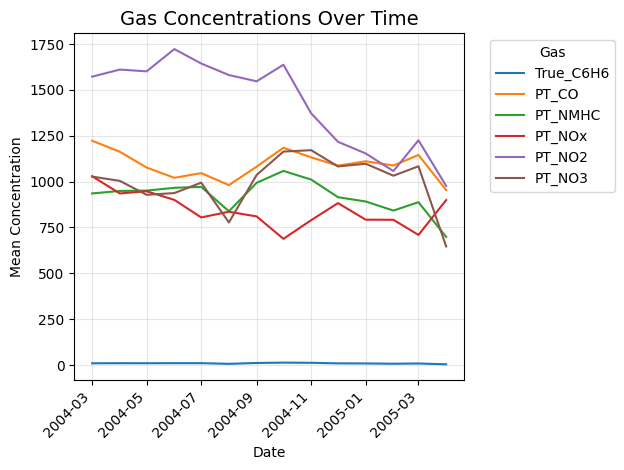

In [27]:
# new df with gas data averaged by month-year to reduce business
gas_df = air_quality.groupby(air_quality["Date"].dt.to_period("M"))[["True_C6H6", "PT_CO", "PT_NMHC", "PT_NOx", "PT_NO2", "PT_NO3"]].mean()

# convert time index to timestamp for plotting
if hasattr(gas_df.index, "to_timestamp"):
    gas_df.index = gas_df.index.to_timestamp()

# plot each gas as a different color
for col in gas_df.columns:
    plt.plot(gas_df.index, gas_df[col], label=col)

plt.title("Gas Concentrations Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Mean Concentration")
plt.legend(title="Gas", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right') # rotate xaxis text for readability


plt.tight_layout()
plt.show()

While `C6H6` is exceedingly hard to view here, it is clear from the other gases that concentrations generally stayed the same over time with the exception of NO2, which decreased over the study period. Since we saw that `C6H6` had a perfect relationship with `PT_NMHC`, we can assume its trend follows the same pattern as the green line, but I'll plot it seperately for better visualization at low concentration numbers.

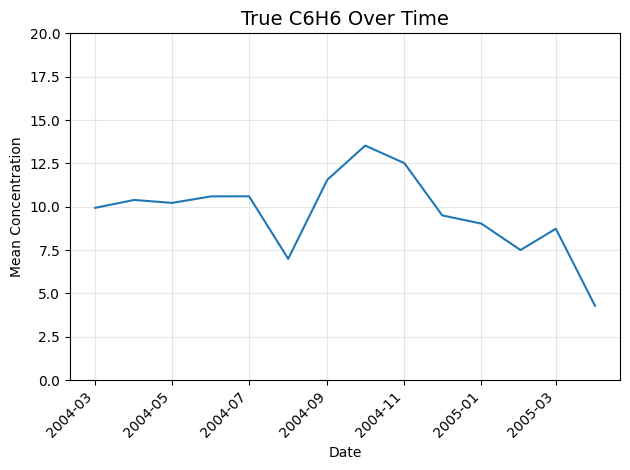

In [29]:
# Plot True_C6H6 from gas_df by itself
plt.plot(gas_df.index, gas_df["True_C6H6"])
plt.title("True C6H6 Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Mean Concentration")
plt.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right') # rotate xaxis text for readability
#expand y axis bounds
plt.ylim(0, 20)

plt.tight_layout()
plt.show()

As expected, this looks identical to `PT_NMHC`. This indicates that the NMHC sensor works as an ideal proxy for atmospheric C6H6 providing a low-cost solution for monitoring the atmospheric pollutant.